In [247]:
import import_ipynb
from Functions import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time
from torch import nn
from torchvision import transforms

# Add Inconsistency

In [248]:
#Add a random inconsistency
def AddOneInc1(F):
    # Convert to NumPy Array
    F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 2 * I.shape[0] // 3), random.randint(0, 2 * I.shape[1] // 3)
    # Random size
    l = random.randint(5,I.shape[1]//20)
    # Random option
    Op = random.randint(0, 5)
    if Op == 0:
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1:
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (R, G, B), (R, G, B))
    elif Op == 2:
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//15)
        I = cv2.line(I, (x, y), (x + l, y + l2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3:
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//20)
        I = cv2.line(I, (x, y), (x + l, y + l2), (0, 0, 0), Thick)  
    elif Op == 4:
        I[x:x+l,y:y+l] = I[x:x+l,y:y+l] + np.random.random_integers(-10,10,I[x:x+l,y:y+l].shape)
    else:
        kernel = np.random.rand(3,3)
        I[x:x+l,y:y+l] = cv2.filter2D(I[x:x+l,y:y+l],-1,kernel)
    # Convert back to tensor
    I_tensor = torch.tensor(I, dtype=torch.float32).permute(2, 0, 1)/255.0
    return I_tensor

# Calculate OF

In [249]:
def OF(img1: torch.Tensor, img2: torch.Tensor, alpha: float = 1.0, iterations: int = 100):
    assert img1.shape == img2.shape, "Images must have the same shape"
    # Convert to grayscale to simplify optical flow calculation
    def rgb_to_grayscale(img):
        return 0.2989 * img[0, :, :] + 0.5870 * img[1, :, :] + 0.1140 * img[2, :, :]

    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)

    # Initialize optical flow vectors (u for x direction, v for y direction)
    u = torch.zeros_like(I1, requires_grad=True)
    v = torch.zeros_like(I1, requires_grad=True)
    
    # Define convolution kernels for gradients
    kernel_x = torch.tensor([[[[-1, 1], [-1, 1]]]], dtype=torch.float32)
    kernel_y = torch.tensor([[[[-1, -1], [1, 1]]]], dtype=torch.float32)

    # Compute gradients with padding that maintains the original image size
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_x, padding=(0, 1)).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_y, padding=(1, 0)).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient

    # Ensure all tensors have matching dimensions by cropping to the smallest dimensions
    min_h = min(Ix.shape[-2], Iy.shape[-2], It.shape[-2], I1.shape[-2])
    min_w = min(Ix.shape[-1], Iy.shape[-1], It.shape[-1], I1.shape[-1])

    # No additional indexing needed here
    Ix = Ix[:min_h, :min_w]
    Iy = Iy[:min_h, :min_w]
    It = It[:min_h, :min_w]
    u = u[:min_h, :min_w]
    v = v[:min_h, :min_w]

    # Iteratively update the optical flow
    for _ in range(iterations):
        # Average flow in the neighborhood
        u_avg = Fun.avg_pool2d(u.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        v_avg = Fun.avg_pool2d(v.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        
        # Optical flow update step based on Horn-Schunck method
        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2
        
        u = u_avg - (Ix * P) / D
        v = v_avg - (Iy * P) / D

    # Stack u and v to form the flow tensor
    flow = torch.stack((u, v), dim=0)
    return flow

# Calculate Histogram

In [250]:
def hist(image, num_bins=256, min_val=0.0, max_val=1.0):
    # Rescale the image to the range [0, num_bins]
    image_scaled = (image - min_val) / (max_val - min_val) * (num_bins - 1)
    # Create bin centers
    bin_centers = torch.linspace(0, num_bins - 1, num_bins, device=image.device)
    # Expand bin centers for broadcasting
    bin_centers = bin_centers.view(1, 1, 1, -1)
    # Compute the soft assignment (weights) to each bin using Gaussian kernel
    histograms = torch.exp(-(image_scaled.unsqueeze(-1) - bin_centers) ** 2)
    # Sum over all pixels to get the histogram
    histograms = histograms.sum(dim=[2, 3])  # Sum over height and width
    # Normalize the histogram to sum to 1
    histograms = histograms / histograms.sum(dim=-1, keepdim=True)
    return histograms

def histogram_loss(image_gen, image_target, num_bins=256):
    # Ensure images are in the range [0, 1]
    image_gen = torch.clamp(image_gen, 0.0, 1.0)
    image_target = torch.clamp(image_target, 0.0, 1.0)
    # Calculate differentiable histograms for generated and target images
    hist_gen = hist(image_gen, num_bins=num_bins)
    hist_target = hist(image_target, num_bins=num_bins)
    # Calculate the histogram difference (L2 norm for histogram loss)
    loss = torch.sum((hist_gen - hist_target) ** 2, dim=-1).mean()
    return loss

# Calculate Difference in Frequency

In [251]:
def frequency_loss(image1, image2):
    # Apply 2D Fourier Transform to the images along the height and width dimensions
    freq_image1 = torch.fft.fft2(image1*255, dim=(-2, -1))
    freq_image2 = torch.fft.fft2(image2*255, dim=(-2, -1))
    # Compute the magnitude of the frequencies (ignore the phase for this loss)
    mag_image1 = torch.abs(freq_image1)
    mag_image2 = torch.abs(freq_image2)
    # Compute the loss between the magnitudes of the frequency components
    loss = Fun.mse_loss(mag_image1, mag_image2)
    return loss

# Main Model

In [252]:
class BinIncModel(nn.Module):
    def __init__(self, N, H, W):
        super(BinIncModel, self).__init__()
        self.N, self.H, self.W = N, H, W
        
        # Convolutional layers with dilated convolutions and batch normalization
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(1, 3, 3), padding=(0, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(16)
        
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(1, 3, 3), dilation=(1, 2, 2), padding=(0, 2, 2))
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(32)
        
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3), padding=(0, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bn3 = nn.BatchNorm3d(64)

        # Spatial Pyramid Pooling to handle varying sizes
        self.spp = SpatialPyramidPooling(output_sizes=[(1, 1), (2, 2), (4, 4)])

        # LSTM layer for temporal dependence
        self.lstm_input_size = 0  # Initialize dynamically
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=128, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        # Permute input for 3D convolutions and calculate difference frames
        x = x.permute(0, 2, 1, 3, 4)
        
        # Convolutional layers with BatchNorm, ReLU, and Max Pooling
        x = self.bn1(Fun.relu(self.conv1(x)))
        x = self.pool1(x)
        
        x = self.bn2(Fun.relu(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.bn3(Fun.relu(self.conv3(x)))
        x = self.pool3(x)

        # Spatial Pyramid Pooling
        x = self.spp(x)

        # Update the LSTM input size dynamically based on the output of SPP
        self.lstm_input_size = x.size(1)  # The size after SPP flattening

        # Now reinitialize the LSTM layer with the correct input size
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=128, batch_first=True)

        # Pass through LSTM to capture temporal dependencies
        x = x.unsqueeze(1)  # Add time dimension
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last LSTM step

        # Fully connected layers with Dropout for regularization
        x = Fun.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

# Get Training Data

In [253]:
def get_video_frames(path, N, size):
    # Find all video files in the specified path
    video_files = [f for f in os.listdir(path) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        raise ValueError("No video files found in the specified path.")
    
    # Choose a random video file
    video_file = random.choice(video_files)
    video_path = os.path.join(path, video_file)
    
    # Initialize the video capture
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If N is larger than the number of frames in the video, adjust it
    if N > total_frames:
        raise ValueError(f"The video has only {total_frames} frames, but {N} frames were requested.")
    
    # Select a random starting frame index such that we can capture N consecutive frames
    start_frame = random.randint(0, total_frames - N)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Resize transformation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    
    frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame (BGR to RGB) and apply the resize transform
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = transform(frame_rgb)
        frames.append(frame_tensor)
    
    cap.release()
    
    # Stack frames and reshape to the desired output shape
    frames_tensor = torch.stack(frames).unsqueeze(0)  # Shape (1, N, 3, H, W)
    
    return frames#_tensor

# Convert Tensor to Numpy List

In [254]:
def t2nl(frames_tensor):
    # Remove the batch dimension (1, N, 3, H, W) -> (N, 3, H, W)
    frames_tensor = frames_tensor.squeeze(0)
    
    # Convert each frame tensor to a NumPy array
    frame_list = [cv2.cvtColor(frame.permute(1, 2, 0).numpy(),cv2.COLOR_BGR2RGB) for frame in frames_tensor]
    
    return frame_list

# Training Function

In [255]:
def train(Path, State=None, N=3, Size=(100, 100), Batch=10, Epochs=10, Steps=5, LR=1e-3):
    model = BinIncModel(N, Size[0], Size[1])
    if State is not None:
        model.load_state_dict(State)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    Loss, LossAll = [], [] 
    LMin = 1e20

    for epoch in range(Epochs):
        total_loss = 0.0
        for batch in range(Batch):
            optimizer.zero_grad()
            
            Frames = get_video_frames(Path, N, Size)
            Target = torch.tensor([0.0]) if random.random() >= 0.5 else torch.tensor([1.0])

            if Target.item() == 1.0:
                steps = random.randint(1, Steps)
                for s in range(steps):
                    Frames[N // 2] = AddOneInc1(Frames[N // 2])
            
            # Difference Frames
            diff_frames = [Frames[i+1] - Frames[i] for i in range(len(Frames) - 1)]
            In = torch.stack(diff_frames).unsqueeze(0)  # Shape [1, N-1, C, H, W]

            # Forward pass
            Pred = model(In).squeeze(0)

            # Calculate loss
            loss = Fun.binary_cross_entropy(Pred, Target)
            loss.backward()
            optimizer.step()

            LossAll.append(loss.item())
            total_loss += loss.item()
            print(f'Batch [{batch+1}/{Batch}], Loss: {loss.item():.6f}', end='\r')

            # Display predictions on the frame
            Frame = cv2.cvtColor(Frames[N // 2].permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
            Frame = cv2.putText(Frame, f'P: {round(Pred.item())}', (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
            Frame = cv2.putText(Frame, f'T: {int(Target.item())}', (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
            cv2.imshow("Frame", Frame)
            cv2.waitKey(1)

        Loss.append(total_loss)
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / Batch:.6f}\n')
        
        if total_loss < LMin:
            LMin = total_loss
            State = model.state_dict()
        else:
            model.load_state_dict(State)
        LR *= 0.9
    
    cv2.destroyAllWindows()
            
    return State,model,Loss

# Training

In [264]:
cv2.destroyAllWindows()

In [270]:
State = None

In [271]:
State,Model,L = train('VDB',Batch=20,State=State,Size=(100,100),N=3,Epochs=10,Steps=5,LR=1e-3)

Batch [20/20], Loss: 0.746668
Epoch [1/10], Loss: 0.714408

Batch [20/20], Loss: 0.675669
Epoch [2/10], Loss: 0.685888

Batch [20/20], Loss: 0.702868
Epoch [3/10], Loss: 0.673241

Batch [20/20], Loss: 0.739484
Epoch [4/10], Loss: 0.679568

Batch [20/20], Loss: 0.726143
Epoch [5/10], Loss: 0.695576

Batch [20/20], Loss: 0.622998
Epoch [6/10], Loss: 0.664638

Batch [20/20], Loss: 0.565636
Epoch [7/10], Loss: 0.684871

Batch [20/20], Loss: 0.793584
Epoch [8/10], Loss: 0.720809

Batch [20/20], Loss: 0.570150
Epoch [9/10], Loss: 0.699210

Batch [20/20], Loss: 0.763766
Epoch [10/10], Loss: 0.727409



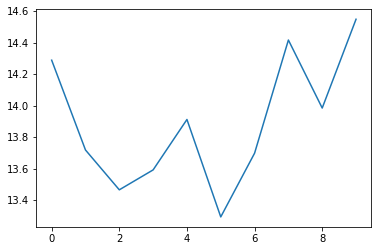

In [272]:
plt.plot(L)

In [282]:
def Prediction(video, model, model_state, N, H, W):
    # Load the model state
    model.load_state_dict(model_state)
    model.eval()  # Set model to evaluation mode
    outputs = []
    # Iterate over the video in steps of N frames
    num_frames = len(video)
    for i in range(0, num_frames - N + 1):
        # Extract the stack of frames
        frame_stack = video[i:i + N]  # Shape: (N, H, W, C)
        # Convert to numpy array and add batch dimension
        frame_stack = np.array(frame_stack)  # Shape: (N, H, W, C)
        # Rearrange to match the model's expected input shape: (batch, N, C, H, W)
        # In our case, the frame_stack shape should be (1, N, 3, H, W) where 3 is the number of channels (RGB)
        frame_stack = np.transpose(frame_stack, (0, 3, 1, 2))  # Shape: (N, C, H, W)
        frame_stack = np.expand_dims(frame_stack, axis=0)  # Shape: (1, N, C, H, W)
        # Convert to a PyTorch tensor
        frame_stack = torch.tensor(frame_stack, dtype=torch.float32)
        # Forward pass through the model
        with torch.no_grad():
            output = model(frame_stack)
        # Append the output to the list
        outputs.append(int(round(output.item())))
    return outputs

In [302]:
cap = open_vid("AI Gen/movie.mp4")
Video = get_frames(cap)
VI = torch.from_numpy(Video[5]).permute(2,0,1).unsqueeze(0)
VI = AddOneInc1(VI)
Video[5] = cv2.cvtColor(VI.permute(1, 2, 0).numpy(),cv2.COLOR_BGR2RGB)
display_frame(Video[5])

In [295]:
Video = [cv2.resize(i,(100,100)) for i in Video[:15]]
Preds = process_video(Video,Model,State,3,100,100)
Preds

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]

In [260]:
def Prediction(Vid,Model,State,N,Size):
    model = BinIncModel(N,Size(0),Size(1))
    P = []
    V = [torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in Vid]
    
    N = len(kt)//2
    for f in range(len(V) - 2 * N):
        first, current, last = f, f + N // 2, f + N
        Pred = ObjFun(V[first:last], V[current], k, kt, kb)
        P.append(cv2.resize((Pred[0] * 255).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8),
                                           (Vid[f].shape[1], Vid[f].shape[0]), interpolation=cv2.INTER_AREA))
    return P

In [ ]:
PVid = Prediction(Video,Parameters)

In [ ]:
ThroughFrames(Video)

In [ ]:
ThroughFrames(PVid)

In [ ]:
##Add detail error, MSE of full image only minimizes general pixel distribution
##Add more training examples
##Add N previous and N post current inconsistence image
##Add optical flow, frequencies or other features for temporal consistency
##Different kernel sizes
##Add Gaisian Noise
##Reconstruct image with kernel middle between encoder and decofer
##Use data with less loss value, selection
##How to combine data with less error and with more error?
##Localize area and correct error

In [ ]:
#deformaciones
#parches de colores, OF ventana
#self attention mechanism
#image processing transformer